{'record_name': 'voice001', 'n_sig': 1, 'fs': 8000, 'counter_freq': None, 'base_counter': None, 'sig_len': 38080, 'base_time': None, 'base_date': None, 'comments': ['<age>: 32  <sex>: M <diagnoses>: hyperkinetic dysphonia <medications>: none'], 'sig_name': ['voice'], 'p_signal': array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       ...,
       [ 0.00354004],
       [-0.03735352],
       [-0.02871704]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['voice001.dat'], 'fmt': ['32'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [4079702243.3775], 'baseline': [-260023747], 'units': ['NU'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [-260023747], 'checksum': [14973], 'block_size': [0]}


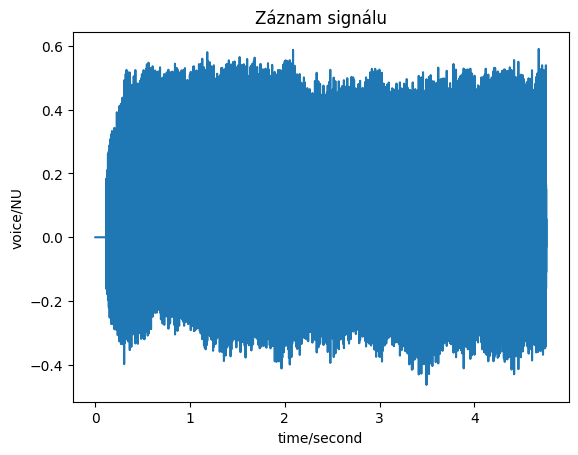

In [ ]:
#úkol: klasifikace zvukových signálů na dobré a patologické pomocí různých technik pomocí Fourierovy a kepstrální analýzy,... v případe klasifikujte poruchy + porovnat s technikami které provedli experti
#výstup: grafy demostrující práci se signálem v časové nebo frekvenční oblasti, viualizace a klasifikace v prosturu nebo pomocí parametrů, tabulka s úspěšností klasifikace na jednotlivé skupiny a patologické signály.
import wfdb
def Nacti_soubor(cesta_k_souboru): return wfdb.rdrecord(cesta_k_souboru)

record = Nacti_soubor(r"C:\Users\Patrik\OneDrive\Plocha\PZS\seminarni_prace_2\zvukove_stopy\voice001") #načtu si zvukový soubor
print(f"{record.__dict__}") #Načtu si informace o zvukové nahrávce, abych věděl, co obsahuje.

signal_data = record.p_signal #vezmu si ze souboru signál zvuku


wfdb.plot_wfdb(record=record, title="Záznam signálu") #vykreslím signal zvuku přes wfdb
